In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import time
from math import exp
from tqdm import tqdm

from rg.monotone import MLP
from rbm.rbm import RBM
from utils.losses import free_energy_contrast
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import batch_grad, grad

lattice = 'lieb'
if lattice == 'lieb':
    from rbm.coupling_matrices import fine_lieb_coupler as fine_coupler, a1_lieb_coupler as coarse_coupler
elif lattice == 'hex':
    from rbm.coupling_matrices import fine_hex_coupler as fine_coupler, coarse_hex_coupler as coarse_coupler

In [2]:
device = torch.device('cuda')

In [3]:
def plot(*functions, xlim=(0, 2)):
    
    x_range = torch.linspace(*xlim, 100, device=device).unsqueeze(1)

    fig, axs = plt.subplots(len(functions), 1, sharex=True, figsize=(8, 2 * len(functions)))

    if len(functions) == 1:
        f_range = functions[0](x_range).cpu().detach()
        axs.plot(x_range.cpu().detach(), f_range)
        axs.axhline(0, color='black', linewidth=0.5)
        axs.axvline(0, color='black', linewidth=0.5)
        
        return fig, axs

    for i, f in enumerate(functions):
        
        f_range = f(x_range).cpu().detach()
        
        axs[i].plot(x_range.cpu().detach(), f_range)
        axs[i].axhline(0, color='black', linewidth=0.5)
        axs[i].axvline(0, color='black', linewidth=0.5)

    return fig, axs

# Models

In [4]:
flow = MLP(
    dim=1, 
    device=device
)
flow.eval();

In [5]:
fine = RBM(fine_coupler, device=device)
coarse = RBM(coarse_coupler, device=device)

In [6]:
sampler = HMC(device=device)

Text(0.5, 1.0, 'Untrained RG Flow (gradient of C-function)')

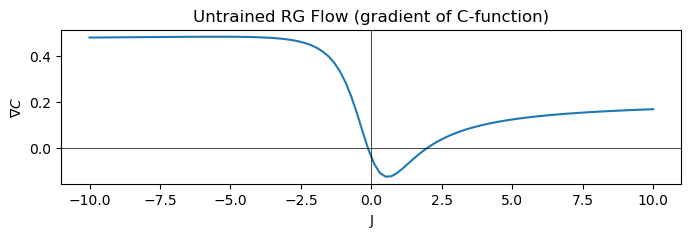

In [7]:
fig, ax = plot(flow, xlim=(-10, 10))
ax.set_ylabel(r'$\nabla C$')
ax.set_xlabel('J')
ax.set_title('Untrained RG Flow (gradient of C-function)')

# Training

In [8]:
epoch = 0
epochs = 1024
sample_batch_size = 32
cd_batch_size = 1024
k_fine = 64
k_coarse = 1

beta = lambda epoch : 64/(1 + exp( -16 * (epoch - (epochs / 2)) / epochs ))

In [9]:
optimizer = torch.optim.Adam(flow.parameters())

Js = []
losses = []
J = torch.randn(sample_batch_size, 1, device=device)

In [ ]:
flow.train()
for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()

    sampler.potential = lambda J : beta(epoch) * (flow(J) ** 2)

    # RG Flow
    J = sampler.step(J).detach()

    loss = 0
    for i in range(sample_batch_size):
        
        fine.J = J[i]
        coarse.J = J[i] + flow(J[i])
    
        # Loss
        loss += free_energy_contrast(
            fine, coarse, 
            batch_size=cd_batch_size, 
            k_fine=k_fine, 
            k_coarse=k_coarse
        )
    
    loss.backward()
    optimizer.step()

    Js.append(J.clone().detach())
    losses.append(float(loss))

 82%|████████████████████████████████▉       | 842/1024 [01:34<00:20,  8.90it/s]

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax0.plot(losses)
ax0.set_ylabel('CD')
ax0.set_title('Contrastive Divergence "Loss"')

for traj in torch.cat(Js, dim=1):
    ax1.plot(traj.cpu().detach(), alpha=0.2, c='black')
ax1.set_ylabel(r'$J_{HMC}$')
ax1.set_xlabel('Epoch')
ax1.set_title('HMC Sampling Trajectories')
plt.tight_layout()

In [ ]:
flow.eval()
fig, axs = plot(
    flow, 
    sampler.potential, 
    xlim=(-2, 2)
)
axs[0].set_ylabel(r'$\nabla C$')
axs[0].set_title(r'Learned RG $\beta$-function')
axs[1].set_xlabel(r'$J$')
axs[1].set_ylabel(r'$U = \beta || \nabla C ||^2$')
axs[1].set_title('HMC Potential Function')
plt.tight_layout()

find_root(torch.tensor([1.], device=device), flow)